In [112]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from tqdm import notebook
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'notebook'
warnings.filterwarnings(action='ignore')


station = pd.read_csv('assets\seoul_bike_station_01_12.csv',encoding='CP949',index_col=0)
near_sub = pd.read_csv('assets/near_sub_station.csv',encoding='CP949',index_col=0)
station_754 = pd.read_hdf('assets\id_754.hdf5')
con_dis= pd.read_csv('assets/con_dis.csv',encoding='CP949',index_col=0)


### 데이터 전처리 id 754만 소팅

In [3]:
# #불러오기
# seoul_bike = pd.read_hdf('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_2021.hdf5')
# # id_754만 sorting
# BM = (seoul_bike['st_id1'] == 754) | (seoul_bike['st_id2'] == 754)
# sort_754 = seoul_bike[BM]

# # 754 to 754 중복 제거
# minus = sort_754.query('st_id1 == 754 & st_id2 == 754').index
# result = sort_754[~sort_754.index.isin(minus)]

# # 저장
# result.reset_index(drop=True,inplace=True)
# result.to_hdf('assets\id_754.hdf5',key='id_754')


* 754 대여소 plot
* 자주 이용하는 지하철역
* 여행지 추천
* 이용 시간대 분석

### 754 대여소 정보

In [4]:
# 대여소 거리측정(haversine 방식이라고 함..)
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

def id_map(id,n, distance=1000, min_count = 500) :
    # 1 to 2 ex) 여의나루 => 다른 대여소
    total_num_left = station_754[station_754['st_id1']== id]['st_id2'].value_counts() # 현재 대여소에서 빌리면 주로 향하는 목적지는?
    total_num_left = total_num_left[: np.where(total_num_left > n)[0][-1]] # 최소 빌린 횟수 설정


    # 2 to 1 ex)다른 대여소 => 여의나루 
    total_num_right = station_754[station_754['st_id2']==id]['st_id1'].value_counts() # 어느 대여소에서 현재 대여소로 이동할까?
    total_num_right = total_num_right[: np.where(total_num_right > n)[0][-1]] # 최소 빌린 횟수 설정


    # concat
    result_concat = pd.concat([total_num_left,total_num_right],axis=1)
    result_concat.fillna((n/2),inplace=True)
    result_concat.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 


    #분석에 필요한 자료 생성
    result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
    result_concat['diff'] = abs((result_concat["1to2"] - result_concat["2to1"])) # 1to2와 2to1 차이
    result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 총 대여 횟수 
    result_concat['category'] = pd.cut(result_concat['rate'], bins=[0,0.45,0.55,result_concat['rate'].max()],
                                                              labels=[f"{id}가 목적지인 대여소", "이동량이 비슷한 대여소" ,f"{id}에서 주로 가는 대여소"])


    #Station 정보 추가                                                          
    add_info_result = pd.merge(result_concat,station, how='left',left_on=result_concat.index,right_on='id') # station 정보 추가
    add_info_result.loc[:,'diff'] = add_info_result['diff'] + 100  # 망할 plotly가 min_size를 구현 안해놔서 이렇게라도 해서 min을 키워야함.


    ## 해당 대여소 100미터 이내 따릉이 기록 제거(fig_1에 해당)
    add_info_result['dist'] = haversine_np(station.query('id==@id')['경도'].values,station.query('id==@id')['위도'].values,add_info_result['경도'].values,add_info_result['위도'].values) # 거리측정
    add_info_result = add_info_result.query('dist > 100')


    # 해당 대여소 1km 반경 내 따릉이 대여소 표시(fig_2에 해당)
    station_haversine = haversine_np(station.query('id==@id')['경도'].values,station.query('id==@id')['위도'].values,station['경도'].values,station['위도'].values)
    station_haversine = pd.concat([station,pd.Series(station_haversine)],axis=1)
    station_haversine.rename(columns={0:'dist'},inplace=True)
    station_haversine = station_haversine.query('@distance >= dist > 0')

    # return add_info_result <= 데이터 점검시 활용




    ### 그래프 그리기 

    # 지역 순위 표시
    fig=px.scatter_mapbox(add_info_result.query(' total > @min_count'), #category != "neutral" & 
            lat="위도",lon="경도",
            hover_name="주소2",
            hover_data=['1to2','2to1','id'],
            color='category',opacity=0.7,
            size='diff', size_max=20,
            color_discrete_map = {f'{id}가 목적지인 대여소': 'midnightblue', 
                                  '이동량이 비슷한 대여소': 'hotpink',
                                  f'{id}에서 주로 가는 대여소': 'coral'},
            zoom=12,height=500,)


    # 반경 내 따릉이 대여소 표현
    fig_2 = go.Figure(go.Scattermapbox(
                name= f'station with in {round(distance/1000,2)}km',
                lat=station_haversine['위도'],
                lon=station_haversine['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=8,color='black',opacity=0.2),
                text=station_haversine['주소2'],
        ))                          
    fig.add_trace(fig_2.data[0])


    # 해당 따릉이 대여소 색 표시
    fig_3 = go.Figure(go.Scattermapbox(
                name='location',
                lat=station.query('id==@id')['위도'],
                lon=station.query('id==@id')['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=10,color='darkgreen',opacity=0.8),
                text=station.query('id==@id')['주소2'].values,
        ))                            
    fig.add_trace(fig_3.data[0])
    fig.update_layout(mapbox_style="carto-positron")

    return fig      

In [102]:
# distance : 해당 지역 주변 따릉이 대여소 띄우기
# min_count : 대여횟수 자체가 n회 이상인 경우
# id_map(754, 10, distance=500, min_count = 150)

### 754 자주가는 지하철역 순위 / 754가 목적지인 지하철역 순위

In [6]:
seoul_bike = pd.read_parquet('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_2021.parquet.gzip')

In [7]:
seoul_bike

#불러오기
# id_754만 sorting

ids=[754,4526,755,746]

result=[]
for st_id in ids : 
    BM = (seoul_bike['st_id1'] == st_id) | (seoul_bike['st_id2'] == st_id)
    sort_754 = seoul_bike[BM]

    # 중복 제거
    minus = sort_754.query('st_id1 == @st_id & st_id2 == @st_id').index
    sorting = sort_754[~sort_754.index.isin(minus)]
    result.append(sorting)


sorted_station = pd.concat(result,axis=0)

sorted_station



,month,day,weekday,by_id,st_id1,st_id2,riding_time,dist,m_pm
6889,7,30,4,32761,103,754,37,7393.03,200.0
6890,7,30,4,37811,103,754,38,7218.34,190.0
20437,7,17,5,52729,112,754,36,5645.63,157.0
23321,7,20,1,44856,113,754,42,6417.72,153.0
27639,7,8,3,38441,115,754,47,6573.02,140.0
...,...,...,...,...,...,...,...,...,...
12547056,6,30,2,34581,746,780,29,3440.14,119.0
12548823,6,30,2,40874,746,755,13,651.84,50.0
12549239,6,30,2,53827,4527,746,6,735.21,123.0
12550563,6,30,2,39614,766,746,5,1235.27,247.0


In [30]:
stat_id = 754
# 200m이내 대여소 찾기
distance = haversine_np(station.loc[station['id']==stat_id,'경도'].values,station.loc[station['id']==stat_id,'위도'].values,station['경도'].values,station['위도'].values) # 거리측정
a = station.copy()
a['distance']= distance
a.dropna(inplace=True)
a.query('distance < 1000').sort_values(by='distance',ascending=False)

,id,주소2,주소1,지역,위도,경도,설치일,distance
525,749,이대 목동병원 앞,서울특별시 양천구 목동 911-10,양천구,37.537228,126.886612,2018-07-04,977.440391
506,726,목동3단지 시내버스정류장,서울특별시 양천구 목동중앙로 49,양천구,37.534389,126.869598,2017-11-01,975.885553
2109,3761,나이아가라관광호텔,양천로743,강서구,37.549030,126.878365,2020-11-11,889.094976
2383,4527,목동신시가지아파트6단지,양천구 목동동로 430(6단지 상가동 앞),양천구,37.536846,126.884750,2021-04-23,856.644266
561,793,목동5단지아파트 534동,서울특별시 양천구 목동동로 350 목동신시가지아파트5단지,양천구,37.533550,126.878143,2020-03-12,853.481146
548,776,목마공원,양평교 하부,양천구,37.538742,126.885681,2020-03-13,836.924654
1789,2703,서울도시가스 앞,강서구 공항대로 607,강서구,37.547485,126.872025,2020-03-16,815.422461
541,768,목동5단지아파트 501동,양천구 목동,양천구,37.535919,126.882446,2020-03-12,771.487315
523,747,목동3단지 상가,서울특별시 양천구 목동 903-6,양천구,37.534580,126.875648,2017-11-01,734.829526
486,700,KB국민은행 염창역 지점 앞,서울특별시 양천구 목동 559,양천구,37.546848,126.872772,2016-06-29,721.457200


In [117]:
## 기본 변수 세팅
stat_id = 754
n = 10

# 754 근처 200m 대여소 아이디 추출

#반복문 수행 
# def finding_substation(sorted_station)
# 754 to 다른 대여소
ids=[754,4526,755,746]
ids=[754]

result=[]
for st_id in ids : 
    BM = (seoul_bike['st_id1'] == st_id) | (seoul_bike['st_id2'] == st_id)
    sort_754 = seoul_bike[BM]

    # 중복 제거
    minus = sort_754.query('st_id1 == @st_id & st_id2 == @st_id').index
    sorting = sort_754[~sort_754.index.isin(minus)]

    total_num_left = sorting[sorting['st_id1']== st_id]['st_id2'].value_counts() # 현재 대여소에서 빌리면 주로 향하는 목적지는?
    total_num_left = total_num_left[: np.where(total_num_left > n)[0][-1]] # 최소 빌린 횟수 설정


    # 다른 대여소 to 754
    total_num_right = sorting[sorting['st_id2']==st_id]['st_id1'].value_counts() # 어느 대여소에서 현재 대여소로 이동할까?
    total_num_right = total_num_right[: np.where(total_num_right > n)[0][-1]] # 최소 빌린 횟수 설정


    # concat
    result_concat = pd.concat([total_num_left,total_num_right],axis=1)
    result_concat.fillna((n/2),inplace=True)
    result_concat.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 
    result.append(result_concat)

result_concat= pd.concat(result,axis=0)
result_concat= result_concat.reset_index().groupby('index')[['1to2','2to1']].sum()

result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 총 대여 횟수 
result_concat['category'] = pd.cut(
                                    result_concat['rate'],
                                    bins=[0,0.45,0.55,result_concat['rate'].max()],
                                    labels=["to", "sim" ,"from"]
                                )
                                        # to : to 754로 기억하자. 해당대여소가 754로 오는 경우가 많다. 0~0.45 => 1to2가 2to1보다 작다. 
                                        # sim : 0.45~0.55 => 1to2와 2to1이 비슷하다. 즉 왕래가 비슷한 대여소이다.
                                        # from : from 754로 기억하자. 754 대여소가 해당 대여소로 향하는 경우가 많음. 0.55~1 => 1to2가 2to1보다 많다.


nearest_sub = pd.merge(result_concat, near_sub, how='left',left_on=result_concat.index,right_on='bike_id')


# return nearest_sub.groupby('역사명')['2to1'].sum().sort_values(ascending=False), nearest_sub.groupby('역사명')['1to2'].sum().sort_values(ascending=False)



In [118]:
len(nearest_sub), 

,1to2,2to1,rate,total,category,sub_id,bike_id,역사명,호선,경도,위도
0,16.0,5.0,0.7619,21.0,from,0,126,NaN,NaN,NaN,NaN
1,5.0,29.0,0.1471,34.0,to,4202,144,공덕,공항철도1호선,126.952024,37.542530
2,17.0,17.0,0.5000,34.0,sim,0,202,NaN,NaN,NaN,NaN
3,40.0,43.0,0.4819,83.0,sim,2528,207,여의나루,5호선,126.932901,37.527098
4,21.0,5.0,0.8077,26.0,from,0,209,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
111,22.0,12.0,0.6471,34.0,from,0,4515,NaN,NaN,NaN,NaN
112,5.0,25.0,0.1667,30.0,to,0,4518,NaN,NaN,NaN,NaN
113,216.0,218.0,0.4977,434.0,sim,0,4526,NaN,NaN,NaN,NaN
114,132.0,78.0,0.6286,210.0,from,0,4527,NaN,NaN,NaN,NaN


In [6]:
# 120 rows × 17 columns
# asd = nearest_sub.query('category == "from"')
print('2to1')
print(nearest_sub.groupby('역사명')['2to1'].sum().sort_values(ascending=False)[:5])
print('\n')
print('1to2')
print(nearest_sub.groupby('역사명')['1to2'].sum().sort_values(ascending=False)[:5])

2to1
역사명
신목동            3400.0
염창              650.0
오목교(목동운동장앞)     471.0
목동              124.0
당산               65.0
Name: 2to1, dtype: float64


1to2
역사명
신목동            3825.0
염창              304.0
오목교(목동운동장앞)     281.0
목동              149.0
신도림             106.0
Name: 1to2, dtype: float64


In [7]:
b = len(add_info_result[add_info_result['category'] == "to"]) # 해당 대여소로 향하는 대여소 수 
c = len(add_info_result[add_info_result['category'] == "sim"]) # 양방향 값이 비슷
d = len(add_info_result[add_info_result['category'] == "from"]) # 해당 대여소가 향하는 대여소 수 

result=[754,b,c,d]

### 여행지 추천

In [8]:
def searching_location(wanting_ids,min_time=1,max_time=200,min_count=5) : 

    # 해당 지역에서 이동하는 지역 소팅
    sorted_st_id2=station_754.query('st_id1 == @wanting_ids')['st_id2'].value_counts()


    # 해당 지역에서 이동하는 지역 소팅
    sorted_st_id2=station_754[station_754['st_id1'] == wanting_ids]['st_id2'].value_counts() 
    min_counts=np.where(sorted_st_id2 >= min_count)[0][-1]


    # 정보 표시
    print(f'검색기준 : 해당 대여소와 최소 {min_count}번 이상 대여기록이 있는 대여소 검색')
    print(f'총 {min_counts}개 대여소 확보')


    result_station = []
    for station_id in notebook.tqdm(sorted_st_id2[:min_counts].index) : 
        '''
            iterate 결과
            10.66it/s 1083.75mb
            7.28it/s 1101.96mb
            5.12it/s 1099.29mib
        '''
        
        # 가장 단순하지만 loop에서 9.21 it/s로 제일빠름
        BM = (station_754['st_id1'] == wanting_ids) & (station_754['st_id2'] == station_id)
        filter_id = station_754[BM]['riding_time'].value_counts().sort_values(ascending=False)
        
        # 여러 값을 한 번에 계산한다는 장점이 있지만 상대적으로 느림 Loop 7.44 it/s
        # BM = (station_754['st_id1'].isin([wanting_ids])) & ((station_754['st_id2'].isin([station_id])))
        # filter_id = station_754['riding_time'][BM].value_counts().sort_values(ascending=False)

        # 시각적으로 직관적이고 간단하게 작성할 수 있음. 그러나 Loop 3.21 it/s 임. 심한 경우 1.44 it/s인 경우도 발생
        # filter_id = station_754.query('st_id1 == @wanting_ids & st_id2 == @station_id')['riding_time'].value_counts().sort_values(ascending=False)

        # 에러 방지차원
        try :
            mean = round(filter_id.index[:3].values.mean(),1)
            percent = round(sum(filter_id[:3].values)/sum(filter_id),2)
            num = sum(filter_id[:3])
            total_num = sum(filter_id)
            result_station.append([station_id,mean,percent,num,total_num])
        except :
            pass
    
    # 자료정리
    sorted_ids = pd.DataFrame(result_station,columns=['id','est_time','percent','num','total_num']).query('num > 10 & @min_time <= est_time <= @max_time')
    sorted_ids.columns = ['id', '예상도착시간', '비율','예상시간 내 도착 횟수' ,'대여소 이용 이력']
    return pd.merge(sorted_ids, station, how='left', on='id').sort_values(by='예상도착시간',ascending=False)

### 시간대별 대여소 분석

In [10]:
# 2021년 휴일 데이터 구해서 평일만 구해보면 출퇴근 시간이 극명하게 갈리려나?
# 주거지역이다보니 출근과는 상관있는데 퇴근과는 상관 없어 보이는듯.

In [66]:
station_754['hour_period']=station_754['time'].apply(lambda x : str(x.hour)  + '~' +   str(x.hour+1))

### 시간

<AxesSubplot:xlabel='hour_period'>

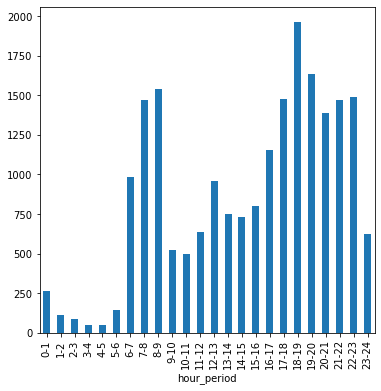

In [79]:
plt.figure(figsize=(6,6))
station_754[~station_754['weekday'].isin([5,6])].groupby('hour_period').size().plot.bar()
# plt.ylim(0,2500)

### 요일별

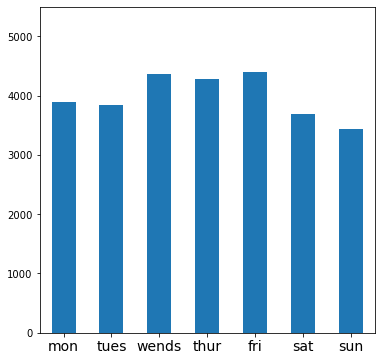

In [80]:
plt.figure(figsize=(6,6))
station_754['weekday'].value_counts().sort_index().plot.bar()

plt.ylim(0,5500)
plt.xticks([0,1,2,3,4,5,6],['mon','tues','wends','thur','fri','sat','sun'],fontsize=14,rotation=0)
plt.show()

### 월별

<AxesSubplot:>

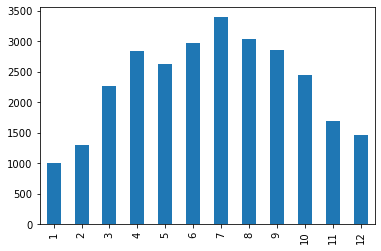

In [76]:
station_754['month'].value_counts().sort_index().plot.bar()

### 시간별 대여소 이동량 변화 측정

In [76]:
# 함수 개선
# 대여소 거리측정(haversine 방식이라고 함..)
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m






def id_map(id,n, distance=1000, min_count = 50,weekday=list(range(7))) :
    # 시간대 나누기
    station_754['hour_period']=station_754['time'].apply(lambda x : str(x.hour)  + '~' +   str(x.hour+1))

    time=[f'{i}~{i+1}' for i in range(24)]

    merge_all =[]
    for hour_period in time :
        station_sorted = station_754[(station_754['hour_period'] == hour_period) & station_754['weekday'].isin(weekday)]
        # 1 to 2 ex) 여의나루 => 다른 대여소
        total_num_left = station_sorted[station_sorted['st_id1']== id]['st_id2'].value_counts() # 현재 대여소에서 빌리면 주로 향하는 목적지는?
        # total_num_left = total_num_left[: np.where(total_num_left > n)[0][-1]] # 최소 빌린 횟수 설정


        # 2 to 1 ex)다른 대여소 => 여의나루 
        total_num_right = station_sorted[station_sorted['st_id2']==id]['st_id1'].value_counts() # 어느 대여소에서 현재 대여소로 이동할까?
        # total_num_right = total_num_right[: np.where(total_num_right > n)[0][-1]] # 최소 빌린 횟수 설정


        # concat
        result_concat = pd.concat([total_num_left,total_num_right],axis=1)
        result_concat.fillna((n/2),inplace=True)
        result_concat.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 


        #분석에 필요한 자료 생성
        result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
        result_concat['diff'] = abs((result_concat["1to2"] - result_concat["2to1"])) # 1to2와 2to1 차이
        result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 총 대여 횟수 
        result_concat['hour_period'] = hour_period
        
        try : 
            result_concat['category'] = pd.cut(result_concat['rate'], bins=[0,0.45,0.55,result_concat['rate'].max()],
                                                                labels=[f"{id}가 목적지인 대여소", "이동량이 비슷한 대여소" ,f"{id}에서 주로 가는 대여소"])
        except :
            # result_concat['category'] = '대여기록 없음'                                       
            print(id)
            # pass

        #Station 정보 추가                                                          
        add_info_result = pd.merge(result_concat,station, how='left',left_on=result_concat.index,right_on='id') # station 정보 추가
        add_info_result.loc[:,'diff'] = add_info_result['diff'] + 100  # 망할 plotly가 min_size를 구현 안해놔서 이렇게라도 해서 min을 키워야함.


        ## 해당 대여소 100미터 이내 따릉이 기록 제거(fig_1에 해당)
        add_info_result['dist'] = haversine_np(station.loc[station['id']==id,'경도'].values,station.loc[station['id']==id,'위도'].values,add_info_result['경도'].values,add_info_result['위도'].values) # 거리측정
        add_info_result = add_info_result[add_info_result['dist'] > 100]
        
        #모으기
        merge_all.append(add_info_result)

    # 합치기
    add_info_result = pd.concat(merge_all,axis=0)

    ### 그래프 그리기 

    # 지역 순위 표시
    fig=px.scatter_mapbox(add_info_result[add_info_result['total'] > min_count],
            lat="위도",lon="경도",
            hover_name="주소2",
            hover_data=['1to2','2to1','id'],
            color='category',opacity=0.7,
            size='total', size_max=20,
            color_discrete_map = {f'{id}가 목적지인 대여소': 'midnightblue', 
                                  '이동량이 비슷한 대여소': 'hotpink',
                                  f'{id}에서 주로 가는 대여소': 'coral'},
            animation_frame='hour_period',
            # animation_group='total',
            zoom=11,height=500,)


    # # 해당 대여소 1km 반경 내 따릉이 대여소 표시(fig_2에 해당)
    # station_haversine = haversine_np(station.loc[station['id']==id,'경도'].
    #                                  values,station.loc[station['id']==id,'위도'].values,
    #                                  station['경도'].values,
    #                                  station['위도'].values
    #                                  )
                                     
    # station_haversine = pd.concat([station,pd.Series(station_haversine)],axis=1)
    # station_haversine.rename(columns={0:'dist'},inplace=True)
    # station_haversine = station_haversine.query('@distance >= dist > 0')

    # # 반경 내 따릉이 대여소 표현
    # fig_2 = go.Figure(go.Scattermapbox(
    #             name= f'station with in {round(distance/1000,2)}km',
    #             lat=station_haversine['위도'],
    #             lon=station_haversine['경도'],
    #             mode='markers',
    #             # marker = {'size': 20, 'symbol': "bus"},
    #             marker=go.scattermapbox.Marker(size=8,color='black',opacity=0.2),
    #             text=station_haversine['주소2'],
    #     ))                          
    # fig.add_trace(fig_2.data[0])


    # 해당 따릉이 대여소 색 표시
    fig_3 = go.Figure(go.Scattermapbox(
                name='location',
                lat=station.query('id==@id')['위도'],
                lon=station.query('id==@id')['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=10,color='darkgreen',opacity=0.8),
                text=station.query('id==@id')['주소2'].values,
        ))                            
    fig.add_trace(fig_3.data[0])
    fig.update_layout(mapbox_style="carto-positron")

    return fig

# id_map(754, 1)['hour_period']